Joan Carles Montero
# Machine Learning-Based Classification of Skin Lesions
## REMOTE binary classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# List the contents of the folder
folder_path = '/content/drive/My Drive/Skin Cancer Lesions Segmentation'
os.listdir(folder_path)

['Skin Cancer- Lesions Segmentation.url',
 '.ipynb_checkpoints',
 'data',
 'images.npy',
 'labels.npy',
 'model',
 'images_mel.npy',
 'labels_mel.npy',
 'model_mel',
 'Skin Cancer segmentation melanoma.ipynb',
 'Skin Cancer segmentation.ipynb',
 'Machine Learning-Based Classification of Skin Lesions.gslides']

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
!export CUDA_VISIBLE_DEVICES=1
!nvidia-smi
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1
Thu Dec  7 11:42:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
# Paths to the data
images_path = os.path.join(folder_path, "images_mel.npy")
#images_path = os.path.join(folder_path, "images_filtered.npy")
labels_path = os.path.join(folder_path, "labels_mel.npy")

# Load the data
images = np.load(images_path, allow_pickle=True)
images_normalized = images.astype(np.float32) / 255.0
labels = np.load(labels_path, allow_pickle=True)
print(images.shape)
print(labels.shape)

# Disordering the data
permuted_indices = np.random.permutation(images.shape[0])

shuffled_images = images[permuted_indices]
shuffled_labels = labels[permuted_indices]

(1008, 225, 300, 3)
(1008,)


In [ ]:
class_sums = labels.sum(axis=0)

class_proportions = class_sums / labels.shape[0]
class_proportions

0.5

In [7]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=1234)

# Convert and normalize the image data
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# Convert labels to the correct type if necessary
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    BatchNormalization(input_shape=(225, 300, 3)),

    Conv2D(16, (5, 5), activation='relu', padding='same'),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),

    Flatten(),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.25),

    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))  # Changed to sigmoid
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,  # Small horizontal shifts to simulate patient movement
    height_shift_range=0.1,  # Small vertical shifts to simulate patient movement
    zoom_range=0.1,  # Slight zooming in/out
    fill_mode='nearest',  # Fill in missing pixels with the nearest filled value
    horizontal_flip=False,
    vertical_flip=False,
)

# Apply the augmentation to the training dataset
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32  # Batch size
)

# Fit the model using the generator
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=25,  # Number of epochs
    steps_per_epoch=len(X_train) // 32  # Number of steps per epoch, typically the size of X_train divided by batch size
)

Epoch 1/25
25/25 [==============================] - 18s 572ms/step - loss: 0.9043 - accuracy: 0.5969 - val_loss: 2.6804 - val_accuracy: 0.5000
Epoch 2/25
25/25 [==============================] - 14s 544ms/step - loss: 0.6707 - accuracy: 0.7481 - val_loss: 1.8700 - val_accuracy: 0.5050
Epoch 3/25
25/25 [==============================] - 12s 466ms/step - loss: 0.6749 - accuracy: 0.6783 - val_loss: 1.6451 - val_accuracy: 0.5198
Epoch 4/25
25/25 [==============================] - 14s 541ms/step - loss: 0.5997 - accuracy: 0.7212 - val_loss: 0.7815 - val_accuracy: 0.6386
Epoch 5/25
25/25 [==============================] - 14s 578ms/step - loss: 0.5895 - accuracy: 0.7377 - val_loss: 0.9752 - val_accuracy: 0.6040
Epoch 6/25
25/25 [==============================] - 14s 568ms/step - loss: 0.5799 - accuracy: 0.7442 - val_loss: 1.0749 - val_accuracy: 0.5594
Epoch 7/25
25/25 [==============================] - 15s 609ms/step - loss: 0.5647 - accuracy: 0.7416 - val_loss: 1.5817 - val_accuracy: 0.5050

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 225, 300, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 225, 300, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 225, 300, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 150, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 150, 32)      9

In [4]:
import tensorflow as tf
model_path = os.path.join(folder_path, 'model_mel')
#model.save(model_path)
model = tf.keras.models.load_model(model_path)

26/26 [==============================] - 65s 2s/step
              precision    recall  f1-score   support

         0.0       0.92      0.58      0.71       403
         1.0       0.70      0.95      0.80       403

    accuracy                           0.77       806
   macro avg       0.81      0.77      0.76       806
weighted avg       0.81      0.77      0.76       806



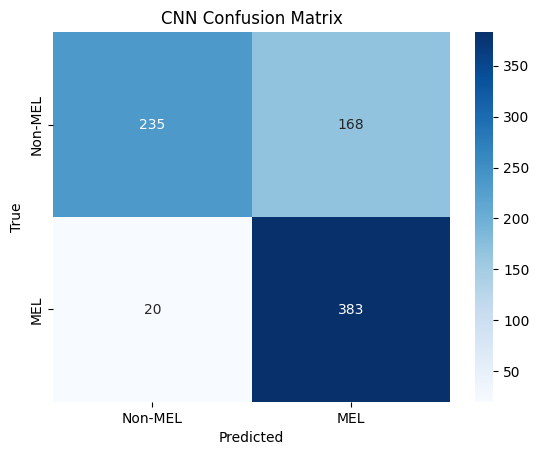

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get probability predictions for the validation set
y_pred_probs = model.predict(X_train)

# Convert probabilities to class labels using 0.5 as a threshold
y_pred = (y_pred_probs > 0.5).astype("int32").reshape(-1)

y_true = y_train

# Print the classification report
print(classification_report(y_true, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

category_names = ['Non-MEL', 'MEL']  # Only two categories
# Confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted')
plt.title('CNN Confusion Matrix')
plt.ylabel('True')
plt.show()

7/7 [==============================] - 12s 2s/step
              precision    recall  f1-score   support

         0.0       0.95      0.59      0.73       101
         1.0       0.71      0.97      0.82       101

    accuracy                           0.78       202
   macro avg       0.83      0.78      0.77       202
weighted avg       0.83      0.78      0.77       202



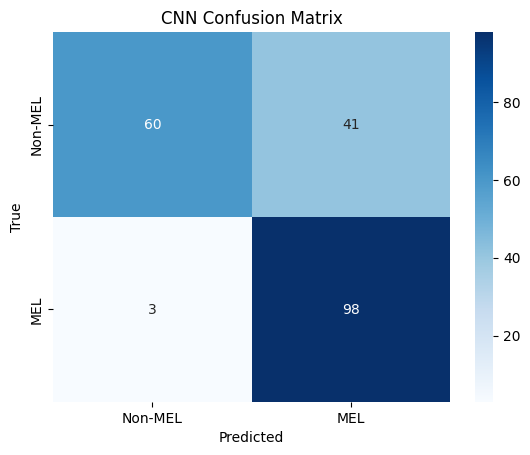

In [12]:
# Get probability predictions for the validation set
y_pred_probs = model.predict(X_val)

# Convert probabilities to class labels using 0.5 as a threshold
y_pred = (y_pred_probs > 0.5).astype("int32").reshape(-1)

y_true = y_val

# Print the classification report
print(classification_report(y_true, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

category_names = ['Non-MEL', 'MEL']  # Only two categories
# Confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix')
plt.show()


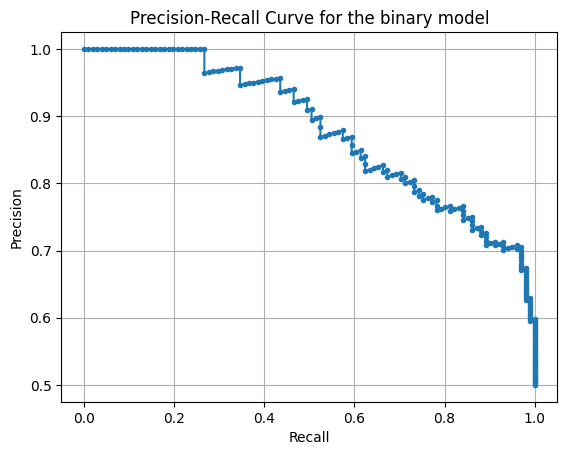

For achieving a recall value of 0.99 for the melanoma class, the threshold should be: 0.22985361516475677


In [10]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)

# Plotting the Precision-Recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for the binary model')
plt.grid(True)
plt.show()

# Function to find the threshold for a given recall value for class 1 (melanoma)
def find_threshold_for_recall(recall_value, recall, thresholds):
    # Finding the index where the recall array is closest to the recall_value
    idx = (np.abs(recall - recall_value)).argmin()
    return thresholds[idx]

# Finding threshold for a certain recall value
recall_value = 0.99
threshold_for_recall = find_threshold_for_recall(recall_value, recall, thresholds)

formatted_print = f"For achieving a recall value of {recall_value} for the melanoma class, the threshold should be: {threshold_for_recall}"
print(formatted_print)


7/7 [==============================] - 12s 2s/step
              precision    recall  f1-score   support

         0.0       0.97      0.34      0.50       101
         1.0       0.60      0.99      0.75       101

    accuracy                           0.66       202
   macro avg       0.79      0.66      0.62       202
weighted avg       0.79      0.66      0.62       202



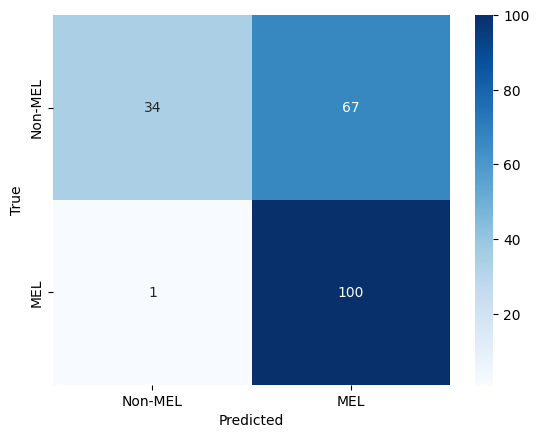

In [13]:
# Get probability predictions for the validation set
y_pred_probs = model.predict(X_val)

# Convert probabilities to class labels using the previous threshold
y_pred = (y_pred_probs > threshold_for_recall).astype("int32").reshape(-1)

y_true = y_val

# Print the classification report
print(classification_report(y_true, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

category_names = ['Non-MEL', 'MEL']  # Only two categories
# Confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
